# Sketchris: Tetris Piece Classifier with PyTorch

This notebook trains a CNN using PyTorch to classify hand-drawn Tetris pieces from the Sketchris dataset.

## Dataset Overview
- **7 Tetris piece types**: I, O, T, S, Z, J, L
- **4 rotations each**: 0°, 90°, 180°, 270°
- **Image format**: 128x128 grayscale PNG
- **Data source**: Hand-drawn sketches collected via data collector tool

In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import defaultdict, Counter
from tqdm import tqdm

# PyTorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn for metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Set random seeds for reproducibility
#random.seed(42)
#np.random.seed(42)
#torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Using device: cuda
PyTorch version: 2.8.0+cu128
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.9 GB


## 1. Dataset Loading and Exploration


In [4]:
# Dataset configuration
DATASET_DIR = "dataset"
IMAGE_SIZE = 128
PIECE_TYPES = ['I_piece', 'O_piece', 'T_piece', 'S_piece', 'Z_piece', 'J_piece', 'L_piece']

def load_dataset_info():
    """Load dataset information without loading images into memory"""
    image_paths = []
    labels = []
    rotations = []
    
    print("Scanning dataset...")
    
    for piece_type in PIECE_TYPES:
        piece_dir = os.path.join(DATASET_DIR, piece_type)
        
        if not os.path.exists(piece_dir):
            print(f"Warning: {piece_dir} not found")
            continue
            
        piece_files = [f for f in os.listdir(piece_dir) if f.endswith('.png')]
        print(f"{piece_type}: {len(piece_files)} images")
        
        for filename in piece_files:
            filepath = os.path.join(piece_dir, filename)
            
            image_paths.append(filepath)
            labels.append(piece_type)
            
            # Extract rotation from filename
            if '_rot' in filename:
                rot_part = filename.split('_rot')[1].split('_')[0]
                rotations.append(int(rot_part))
            else:
                rotations.append(0)
    
    return image_paths, labels, rotations

# Load dataset information
image_paths, labels, rotations = load_dataset_info()

print(f"\nDataset summary:")
print(f"Total images: {len(image_paths)}")
print(f"Unique piece types: {len(set(labels))}")
print(f"Unique rotations: {sorted(set(rotations))}")

# Create label encoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"\nClass mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {i}: {class_name.replace('_', ' ').title()}")


Scanning dataset...
I_piece: 92 images
O_piece: 88 images
T_piece: 83 images
S_piece: 78 images
Z_piece: 85 images
J_piece: 86 images
L_piece: 83 images

Dataset summary:
Total images: 595
Unique piece types: 7
Unique rotations: [0, 90, 180, 270]

Class mapping:
  0: I Piece
  1: J Piece
  2: L Piece
  3: O Piece
  4: S Piece
  5: T Piece
  6: Z Piece


=== DATASET STATISTICS ===
\nImages per piece type:
  I Piece: 92
  J Piece: 86
  L Piece: 83
  O Piece: 88
  S Piece: 78
  T Piece: 83
  Z Piece: 85
\nImages per rotation:
  0°: 207
  90°: 130
  180°: 137
  270°: 121


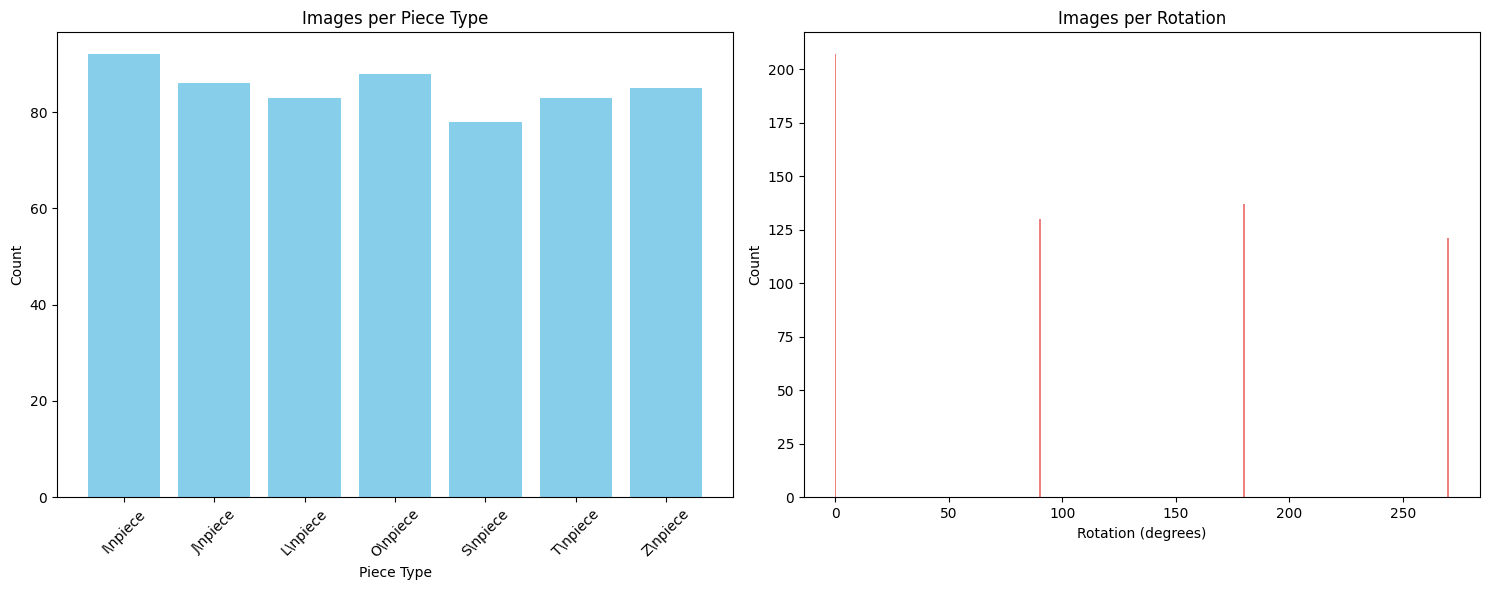

In [5]:
# Dataset statistics and visualization
print("=== DATASET STATISTICS ===")

# Count by piece type
piece_counts = Counter(labels)
print("\\nImages per piece type:")
for piece, count in sorted(piece_counts.items()):
    print(f"  {piece.replace('_', ' ').title()}: {count}")

# Count by rotation
rotation_counts = Counter(rotations)
print("\\nImages per rotation:")
for rotation, count in sorted(rotation_counts.items()):
    print(f"  {rotation}°: {count}")

# Visualize dataset distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Piece type distribution
piece_counts_df = pd.Series(piece_counts).sort_index()
axes[0].bar(range(len(piece_counts_df)), piece_counts_df.values, color='skyblue')
axes[0].set_title('Images per Piece Type')
axes[0].set_xlabel('Piece Type')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(piece_counts_df)))
axes[0].set_xticklabels([p.replace('_', '\\n') for p in piece_counts_df.index], rotation=45)

# Rotation distribution
rotation_counts_df = pd.Series(rotation_counts).sort_index()
axes[1].bar(rotation_counts_df.index, rotation_counts_df.values, color='lightcoral')
axes[1].set_title('Images per Rotation')
axes[1].set_xlabel('Rotation (degrees)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


## 2. PyTorch Dataset and DataLoaders


In [6]:
class TetrisPieceDataset(Dataset):
    """Custom PyTorch Dataset for Tetris pieces"""
    
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('L')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Convert label to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return image, label


In [7]:
# Define transforms with MORE aggressive augmentation for small dataset
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # More aggressive augmentation for small datasets
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
    # Normalize to improve convergence
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Same normalization as training
])

# Split data indices first
from sklearn.model_selection import train_test_split

# First split: train vs temp (val+test)
train_indices, temp_indices = train_test_split(
    range(len(image_paths)), test_size=0.3, random_state=41, 
    stratify=encoded_labels
)

# Second split: val vs test
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=42,
    stratify=[encoded_labels[i] for i in temp_indices]
)

# Create separate datasets with appropriate transforms
train_dataset = TetrisPieceDataset(
    [image_paths[i] for i in train_indices],
    [encoded_labels[i] for i in train_indices],
    transform=train_transform
)

val_dataset = TetrisPieceDataset(
    [image_paths[i] for i in val_indices],
    [encoded_labels[i] for i in val_indices],
    transform=val_test_transform
)

test_dataset = TetrisPieceDataset(
    [image_paths[i] for i in test_indices],
    [encoded_labels[i] for i in test_indices],
    transform=val_test_transform
)

print(f"Dataset split:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples") 
print(f"  Test: {len(test_dataset)} samples")


Dataset split:
  Training: 416 samples
  Validation: 89 samples
  Test: 90 samples


DataLoaders created:
  Batch size: 32
  Training batches: 13
  Validation batches: 3
  Test batches: 3


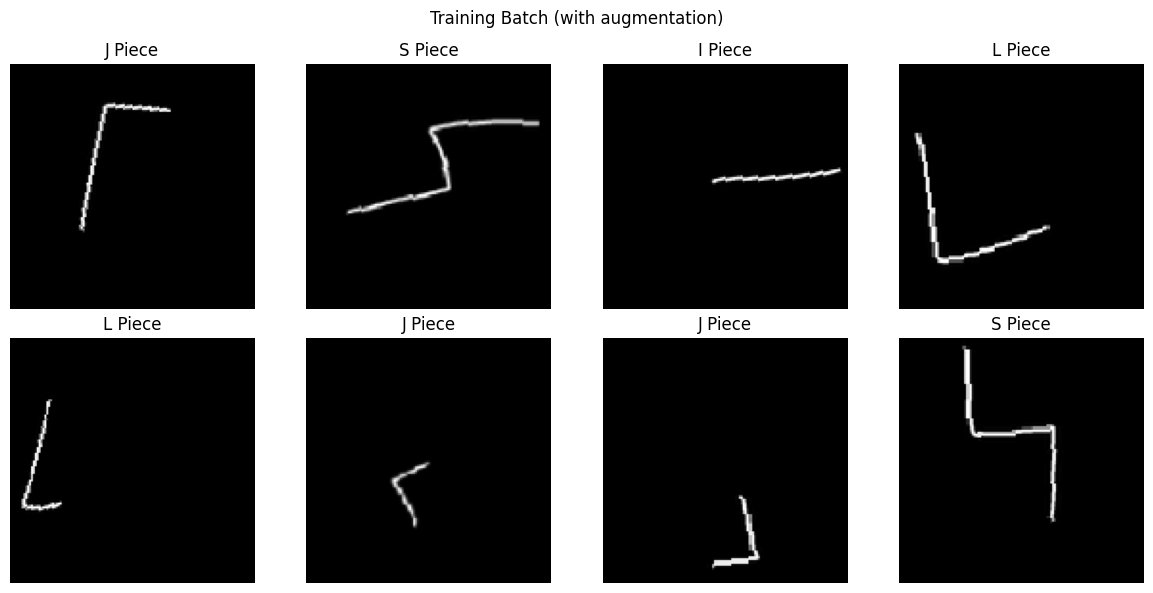

In [8]:
# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Visualize a batch
def show_batch(loader, title):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(8, len(images))):
        img = images[i].squeeze()
        label_idx = labels[i].item()
        label_name = label_encoder.classes_[label_idx]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"{label_name.replace('_', ' ').title()}")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_batch(train_loader, "Training Batch (with augmentation)")


## 3. Model Architecture


In [9]:
class TetrisCNN(nn.Module):
    """CNN model for Tetris piece classification"""
    
    def __init__(self, num_classes):
        super(TetrisCNN, self).__init__()
        
        # First convolutional block - smaller kernels for finer details
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.1)  # Reduced dropout to retain more features
        
        # Second convolutional block - focus on shape patterns
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.15)
        
        # Third convolutional block - deeper feature extraction
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.2)
        
        # Fourth convolutional block for fine-grained features
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(0.2)
        
        # Calculate the size after convolutions  
        # 128 -> 64 -> 32 -> 16 -> 8, so 8x8x512 = 32768
        self.fc1 = nn.Linear(8 * 8 * 512, 1024)
        self.bn8 = nn.BatchNorm1d(1024)
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.bn9 = nn.BatchNorm1d(512)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)
        self.bn10 = nn.BatchNorm1d(256)
        self.dropout7 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(256, num_classes)
        
        # Initialize weights for better convergence
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # First block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Fourth block
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Flatten and fully connected layers
        x = x.view(-1, 8 * 8 * 512)
        x = F.relu(self.bn8(self.fc1(x)))
        x = self.dropout5(x)
        x = F.relu(self.bn9(self.fc2(x)))
        x = self.dropout6(x)
        x = F.relu(self.bn10(self.fc3(x)))
        x = self.dropout7(x)
        x = self.fc4(x)
        
        return x

# Create model and move to device
model = TetrisCNN(num_classes).to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created:")
print(f"  Total parameters: {count_parameters(model):,}")
print(f"  Model on device: {next(model.parameters()).device}")
print(f"\\nModel architecture:")
print(model)


Model created:
  Total parameters: 36,544,199
  Model on device: cuda:0
\nModel architecture:
TetrisCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.1, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropou

## 4. Training Setup and Loop


In [10]:
# Training configuration
LEARNING_RATE = 0.02
NUM_EPOCHS = 100
PATIENCE = 100

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"Training configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Max epochs: {NUM_EPOCHS}")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau (patience=5)")
print(f"  Early stopping: patience={PATIENCE}")


Training configuration:
  Learning rate: 0.02
  Max epochs: 100
  Optimizer: Adam
  Loss function: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau (patience=5)
  Early stopping: patience=100


In [11]:
# Training and validation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("Training and validation functions defined")


Training and validation functions defined


In [12]:
# Training loop with early stopping
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0
epochs_without_improvement = 0
best_model_state = None

print("Starting training...")
print("=" * 50)

for epoch in range(NUM_EPOCHS):
    print(f"\\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping and best model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_tetris_model.pth')
        print(f"New best model saved! Validation accuracy: {val_acc:.2f}%")
    else:
        epochs_without_improvement += 1
        
    if epochs_without_improvement >= PATIENCE:
        print(f"\\nEarly stopping after {epoch+1} epochs")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\\nLoaded best model with validation accuracy: {best_val_acc:.2f}%")

print("\\nTraining completed!")


Starting training...
\nEpoch 1/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 18.56it/s]


Train Loss: 2.2263, Train Acc: 19.23%
Val Loss: 15.2977, Val Acc: 19.10%
New best model saved! Validation accuracy: 19.10%
\nEpoch 2/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.68it/s]


Train Loss: 2.1626, Train Acc: 19.47%
Val Loss: 1.7218, Val Acc: 33.71%
New best model saved! Validation accuracy: 33.71%
\nEpoch 3/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.95it/s]


Train Loss: 1.9523, Train Acc: 25.48%
Val Loss: 1.8830, Val Acc: 26.97%
\nEpoch 4/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.59it/s]


Train Loss: 1.8958, Train Acc: 26.44%
Val Loss: 1.7587, Val Acc: 33.71%
\nEpoch 5/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.55it/s]


Train Loss: 1.8917, Train Acc: 29.81%
Val Loss: 1.6737, Val Acc: 32.58%
\nEpoch 6/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.39it/s]


Train Loss: 1.7325, Train Acc: 32.21%
Val Loss: 1.5561, Val Acc: 38.20%
New best model saved! Validation accuracy: 38.20%
\nEpoch 7/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.64it/s]


Train Loss: 1.7861, Train Acc: 32.69%
Val Loss: 1.4962, Val Acc: 43.82%
New best model saved! Validation accuracy: 43.82%
\nEpoch 8/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.09it/s]


Train Loss: 1.7790, Train Acc: 29.33%
Val Loss: 1.4825, Val Acc: 44.94%
New best model saved! Validation accuracy: 44.94%
\nEpoch 9/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.03it/s]


Train Loss: 1.6701, Train Acc: 35.10%
Val Loss: 1.4179, Val Acc: 47.19%
New best model saved! Validation accuracy: 47.19%
\nEpoch 10/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.34it/s]


Train Loss: 1.6242, Train Acc: 35.82%
Val Loss: 1.4285, Val Acc: 47.19%
\nEpoch 11/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.56it/s]


Train Loss: 1.6448, Train Acc: 35.82%
Val Loss: 1.3856, Val Acc: 44.94%
\nEpoch 12/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.68it/s]


Train Loss: 1.6065, Train Acc: 34.38%
Val Loss: 1.3312, Val Acc: 49.44%
New best model saved! Validation accuracy: 49.44%
\nEpoch 13/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.82it/s]


Train Loss: 1.5439, Train Acc: 38.94%
Val Loss: 1.3198, Val Acc: 53.93%
New best model saved! Validation accuracy: 53.93%
\nEpoch 14/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.83it/s]


Train Loss: 1.5891, Train Acc: 37.98%
Val Loss: 1.3199, Val Acc: 50.56%
\nEpoch 15/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.30it/s]


Train Loss: 1.5165, Train Acc: 41.11%
Val Loss: 1.6069, Val Acc: 37.08%
\nEpoch 16/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.20it/s]


Train Loss: 1.5294, Train Acc: 41.35%
Val Loss: 2.1565, Val Acc: 23.60%
\nEpoch 17/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.94it/s]


Train Loss: 1.5991, Train Acc: 41.11%
Val Loss: 1.2913, Val Acc: 48.31%
\nEpoch 18/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.78it/s]


Train Loss: 1.4839, Train Acc: 41.59%
Val Loss: 1.2348, Val Acc: 55.06%
New best model saved! Validation accuracy: 55.06%
\nEpoch 19/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 35.75it/s]


Train Loss: 1.5028, Train Acc: 39.66%
Val Loss: 1.2179, Val Acc: 53.93%
\nEpoch 20/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 29.24it/s]


Train Loss: 1.4959, Train Acc: 42.07%
Val Loss: 1.2701, Val Acc: 52.81%
\nEpoch 21/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 30.17it/s]


Train Loss: 1.5360, Train Acc: 42.31%
Val Loss: 1.1882, Val Acc: 50.56%
\nEpoch 22/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 30.98it/s]


Train Loss: 1.4507, Train Acc: 43.03%
Val Loss: 1.1914, Val Acc: 51.69%
\nEpoch 23/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 34.99it/s]


Train Loss: 1.4051, Train Acc: 46.39%
Val Loss: 1.4321, Val Acc: 48.31%
\nEpoch 24/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 42.47it/s]


Train Loss: 1.4303, Train Acc: 45.19%
Val Loss: 1.1716, Val Acc: 53.93%
\nEpoch 25/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 43.66it/s]


Train Loss: 1.4913, Train Acc: 41.83%
Val Loss: 1.1632, Val Acc: 53.93%
\nEpoch 26/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]


Train Loss: 1.3940, Train Acc: 48.08%
Val Loss: 1.1211, Val Acc: 66.29%
New best model saved! Validation accuracy: 66.29%
\nEpoch 27/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.82it/s]


Train Loss: 1.3916, Train Acc: 49.04%
Val Loss: 1.1702, Val Acc: 56.18%
\nEpoch 28/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 31.97it/s]


Train Loss: 1.3600, Train Acc: 47.60%
Val Loss: 1.1211, Val Acc: 58.43%
\nEpoch 29/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 35.39it/s]


Train Loss: 1.3707, Train Acc: 47.60%
Val Loss: 1.4859, Val Acc: 44.94%
\nEpoch 30/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 31.87it/s]


Train Loss: 1.3124, Train Acc: 50.48%
Val Loss: 1.0479, Val Acc: 59.55%
\nEpoch 31/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 29.25it/s]


Train Loss: 1.3613, Train Acc: 50.48%
Val Loss: 1.1335, Val Acc: 56.18%
\nEpoch 32/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.72it/s]


Train Loss: 1.3245, Train Acc: 47.36%
Val Loss: 1.1928, Val Acc: 57.30%
\nEpoch 33/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.53it/s]


Train Loss: 1.2609, Train Acc: 52.16%
Val Loss: 0.9032, Val Acc: 65.17%
\nEpoch 34/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.79it/s]


Train Loss: 1.1652, Train Acc: 55.77%
Val Loss: 0.9715, Val Acc: 61.80%
\nEpoch 35/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.22it/s]


Train Loss: 1.1747, Train Acc: 55.05%
Val Loss: 0.9982, Val Acc: 65.17%
\nEpoch 36/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.76it/s]


Train Loss: 1.2163, Train Acc: 55.05%
Val Loss: 0.8287, Val Acc: 74.16%
New best model saved! Validation accuracy: 74.16%
\nEpoch 37/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.73it/s]


Train Loss: 1.1476, Train Acc: 57.93%
Val Loss: 1.0443, Val Acc: 60.67%
\nEpoch 38/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.40it/s]


Train Loss: 1.1129, Train Acc: 56.01%
Val Loss: 0.7270, Val Acc: 74.16%
\nEpoch 39/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.78it/s]


Train Loss: 1.1187, Train Acc: 57.93%
Val Loss: 0.7652, Val Acc: 73.03%
\nEpoch 40/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.35it/s]


Train Loss: 1.1233, Train Acc: 55.77%
Val Loss: 0.7203, Val Acc: 75.28%
New best model saved! Validation accuracy: 75.28%
\nEpoch 41/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.40it/s]


Train Loss: 1.0352, Train Acc: 62.74%
Val Loss: 1.2794, Val Acc: 55.06%
\nEpoch 42/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.58it/s]


Train Loss: 0.9854, Train Acc: 61.78%
Val Loss: 4.5384, Val Acc: 31.46%
\nEpoch 43/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.50it/s]


Train Loss: 0.8735, Train Acc: 68.51%
Val Loss: 1.1113, Val Acc: 64.04%
\nEpoch 44/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 35.95it/s]


Train Loss: 0.9748, Train Acc: 64.42%
Val Loss: 0.6968, Val Acc: 76.40%
New best model saved! Validation accuracy: 76.40%
\nEpoch 45/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.09it/s]


Train Loss: 0.9325, Train Acc: 61.06%
Val Loss: 0.6980, Val Acc: 73.03%
\nEpoch 46/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.34it/s]


Train Loss: 0.9362, Train Acc: 64.66%
Val Loss: 0.7674, Val Acc: 71.91%
\nEpoch 47/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.47it/s]


Train Loss: 0.8902, Train Acc: 64.90%
Val Loss: 0.6221, Val Acc: 77.53%
New best model saved! Validation accuracy: 77.53%
\nEpoch 48/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.19it/s]


Train Loss: 0.8667, Train Acc: 69.47%
Val Loss: 0.5582, Val Acc: 77.53%
\nEpoch 49/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.64it/s]


Train Loss: 0.8783, Train Acc: 68.27%
Val Loss: 0.6275, Val Acc: 76.40%
\nEpoch 50/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.40it/s]


Train Loss: 0.8916, Train Acc: 67.31%
Val Loss: 0.5916, Val Acc: 71.91%
\nEpoch 51/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.38it/s]


Train Loss: 0.7842, Train Acc: 69.71%
Val Loss: 0.5843, Val Acc: 79.78%
New best model saved! Validation accuracy: 79.78%
\nEpoch 52/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.98it/s]


Train Loss: 0.8397, Train Acc: 67.79%
Val Loss: 4.3843, Val Acc: 33.71%
\nEpoch 53/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.01it/s]


Train Loss: 0.7471, Train Acc: 72.60%
Val Loss: 0.5459, Val Acc: 76.40%
\nEpoch 54/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.06it/s]


Train Loss: 0.7769, Train Acc: 70.19%
Val Loss: 0.4785, Val Acc: 83.15%
New best model saved! Validation accuracy: 83.15%
\nEpoch 55/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.46it/s]


Train Loss: 0.7694, Train Acc: 75.48%
Val Loss: 3.7421, Val Acc: 32.58%
\nEpoch 56/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.00it/s]


Train Loss: 0.6133, Train Acc: 75.72%
Val Loss: 0.5648, Val Acc: 79.78%
\nEpoch 57/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.63it/s]


Train Loss: 0.7679, Train Acc: 75.24%
Val Loss: 0.4340, Val Acc: 82.02%
\nEpoch 58/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.29it/s]


Train Loss: 0.6719, Train Acc: 75.00%
Val Loss: 0.7545, Val Acc: 70.79%
\nEpoch 59/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 34.22it/s]


Train Loss: 0.7278, Train Acc: 71.15%
Val Loss: 0.5987, Val Acc: 77.53%
\nEpoch 60/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.66it/s]


Train Loss: 0.6914, Train Acc: 77.16%
Val Loss: 1.1939, Val Acc: 61.80%
\nEpoch 61/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.20it/s]


Train Loss: 0.7412, Train Acc: 75.24%
Val Loss: 0.4661, Val Acc: 85.39%
New best model saved! Validation accuracy: 85.39%
\nEpoch 62/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.12it/s]


Train Loss: 0.6767, Train Acc: 73.56%
Val Loss: 0.4245, Val Acc: 86.52%
New best model saved! Validation accuracy: 86.52%
\nEpoch 63/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.07it/s]


Train Loss: 0.6583, Train Acc: 74.52%
Val Loss: 0.4510, Val Acc: 85.39%
\nEpoch 64/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.19it/s]


Train Loss: 0.7293, Train Acc: 74.04%
Val Loss: 0.3385, Val Acc: 87.64%
New best model saved! Validation accuracy: 87.64%
\nEpoch 65/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.68it/s]


Train Loss: 0.6178, Train Acc: 79.33%
Val Loss: 0.4285, Val Acc: 83.15%
\nEpoch 66/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.41it/s]


Train Loss: 0.5838, Train Acc: 77.64%
Val Loss: 0.4357, Val Acc: 85.39%
\nEpoch 67/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.20it/s]


Train Loss: 0.6346, Train Acc: 79.33%
Val Loss: 0.3825, Val Acc: 84.27%
\nEpoch 68/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.45it/s]


Train Loss: 0.5809, Train Acc: 79.33%
Val Loss: 0.4489, Val Acc: 87.64%
\nEpoch 69/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.10it/s]


Train Loss: 0.5980, Train Acc: 80.29%
Val Loss: 0.4335, Val Acc: 84.27%
\nEpoch 70/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.47it/s]


Train Loss: 0.6552, Train Acc: 75.00%
Val Loss: 0.4728, Val Acc: 83.15%
\nEpoch 71/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.58it/s]


Train Loss: 0.5533, Train Acc: 81.97%
Val Loss: 0.3702, Val Acc: 88.76%
New best model saved! Validation accuracy: 88.76%
\nEpoch 72/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.91it/s]


Train Loss: 0.4648, Train Acc: 83.41%
Val Loss: 0.3421, Val Acc: 89.89%
New best model saved! Validation accuracy: 89.89%
\nEpoch 73/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.63it/s]


Train Loss: 0.3910, Train Acc: 86.06%
Val Loss: 0.3244, Val Acc: 93.26%
New best model saved! Validation accuracy: 93.26%
\nEpoch 74/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.46it/s]


Train Loss: 0.3902, Train Acc: 86.30%
Val Loss: 0.3137, Val Acc: 93.26%
\nEpoch 75/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.27it/s]


Train Loss: 0.4251, Train Acc: 84.13%
Val Loss: 0.3234, Val Acc: 92.13%
\nEpoch 76/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.36it/s]


Train Loss: 0.4933, Train Acc: 82.21%
Val Loss: 0.3168, Val Acc: 88.76%
\nEpoch 77/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.98it/s]


Train Loss: 0.3935, Train Acc: 85.34%
Val Loss: 0.3220, Val Acc: 92.13%
\nEpoch 78/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.41it/s]


Train Loss: 0.3489, Train Acc: 87.02%
Val Loss: 0.3143, Val Acc: 91.01%
\nEpoch 79/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.40it/s]


Train Loss: 0.3643, Train Acc: 86.30%
Val Loss: 0.3106, Val Acc: 88.76%
\nEpoch 80/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.15it/s]


Train Loss: 0.3062, Train Acc: 89.66%
Val Loss: 0.3090, Val Acc: 91.01%
\nEpoch 81/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.07it/s]


Train Loss: 0.3087, Train Acc: 89.18%
Val Loss: 0.2978, Val Acc: 91.01%
\nEpoch 82/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.70it/s]


Train Loss: 0.3553, Train Acc: 87.50%
Val Loss: 0.2975, Val Acc: 91.01%
\nEpoch 83/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.38it/s]


Train Loss: 0.3953, Train Acc: 86.78%
Val Loss: 0.3058, Val Acc: 89.89%
\nEpoch 84/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 39.80it/s]


Train Loss: 0.3578, Train Acc: 85.58%
Val Loss: 0.3535, Val Acc: 88.76%
\nEpoch 85/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.99it/s]


Train Loss: 0.3300, Train Acc: 88.94%
Val Loss: 0.3601, Val Acc: 87.64%
\nEpoch 86/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 34.43it/s]


Train Loss: 0.3551, Train Acc: 88.22%
Val Loss: 0.2978, Val Acc: 89.89%
\nEpoch 87/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 35.46it/s]


Train Loss: 0.3139, Train Acc: 88.46%
Val Loss: 0.3047, Val Acc: 91.01%
\nEpoch 88/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 36.30it/s]


Train Loss: 0.3430, Train Acc: 88.70%
Val Loss: 0.3327, Val Acc: 88.76%
\nEpoch 89/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.73it/s]


Train Loss: 0.2841, Train Acc: 90.38%
Val Loss: 0.2940, Val Acc: 88.76%
\nEpoch 90/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 37.62it/s]


Train Loss: 0.3325, Train Acc: 88.70%
Val Loss: 0.2699, Val Acc: 88.76%
\nEpoch 91/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 36.26it/s]


Train Loss: 0.2883, Train Acc: 89.90%
Val Loss: 0.2598, Val Acc: 92.13%
\nEpoch 92/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 38.56it/s]


Train Loss: 0.2812, Train Acc: 90.62%
Val Loss: 0.2657, Val Acc: 93.26%
\nEpoch 93/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 28.02it/s]


Train Loss: 0.2682, Train Acc: 89.66%
Val Loss: 0.2927, Val Acc: 89.89%
\nEpoch 94/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.01it/s]


Train Loss: 0.2890, Train Acc: 91.11%
Val Loss: 0.2917, Val Acc: 89.89%
\nEpoch 95/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.59it/s]


Train Loss: 0.2838, Train Acc: 89.66%
Val Loss: 0.2949, Val Acc: 91.01%
\nEpoch 96/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.79it/s]


Train Loss: 0.3481, Train Acc: 88.70%
Val Loss: 0.2881, Val Acc: 89.89%
\nEpoch 97/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.19it/s]


Train Loss: 0.2776, Train Acc: 91.11%
Val Loss: 0.2811, Val Acc: 88.76%
\nEpoch 98/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 40.49it/s]


Train Loss: 0.2513, Train Acc: 90.87%
Val Loss: 0.2766, Val Acc: 91.01%
\nEpoch 99/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.18it/s]


Train Loss: 0.2321, Train Acc: 91.59%
Val Loss: 0.2773, Val Acc: 88.76%
\nEpoch 100/100


Validation: 100%|██████████| 3/3 [00:00<00:00, 41.40it/s]

Train Loss: 0.2697, Train Acc: 91.59%
Val Loss: 0.2867, Val Acc: 89.89%
\nLoaded best model with validation accuracy: 93.26%
\nTraining completed!


## 5. Training Visualization and Evaluation


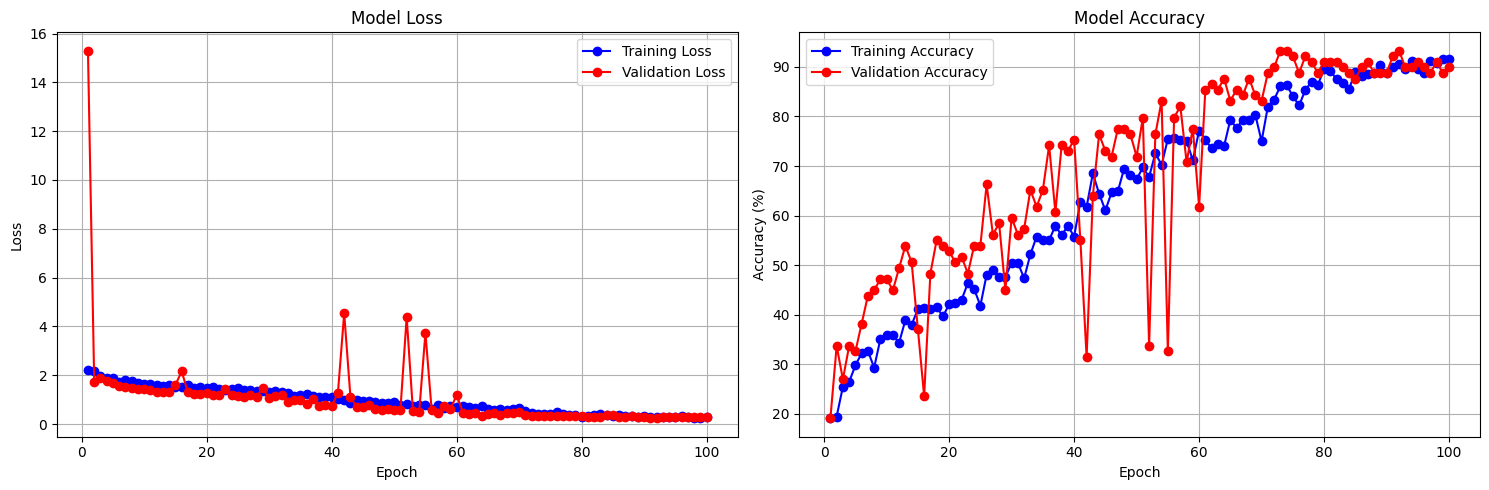

Training Summary:
  Best validation accuracy: 93.26%
  Final training accuracy: 91.59%
  Final validation accuracy: 89.89%
  Total epochs: 100


In [13]:
# Plot training history
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    epochs = range(1, len(train_losses) + 1)
    axes[0].plot(epochs, train_losses, 'bo-', label='Training Loss')
    axes[0].plot(epochs, val_losses, 'ro-', label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    axes[1].plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    axes[1].plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training Summary:")
    print(f"  Best validation accuracy: {max(val_accs):.2f}%")
    print(f"  Final training accuracy: {train_accs[-1]:.2f}%")
    print(f"  Final validation accuracy: {val_accs[-1]:.2f}%")
    print(f"  Total epochs: {len(train_losses)}")

plot_training_history(train_losses, train_accs, val_losses, val_accs)


Evaluating on test set...


Testing: 100%|██████████| 3/3 [00:00<00:00, 17.15it/s]

\nTest Results:
  Test Accuracy: 93.33%
\nClassification Report:
              precision    recall  f1-score   support

     I Piece       1.00      1.00      1.00        14
     J Piece       0.91      0.77      0.83        13
     L Piece       0.80      0.92      0.86        13
     O Piece       1.00      1.00      1.00        13
     S Piece       0.91      0.91      0.91        11
     T Piece       1.00      0.92      0.96        13
     Z Piece       0.93      1.00      0.96        13

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



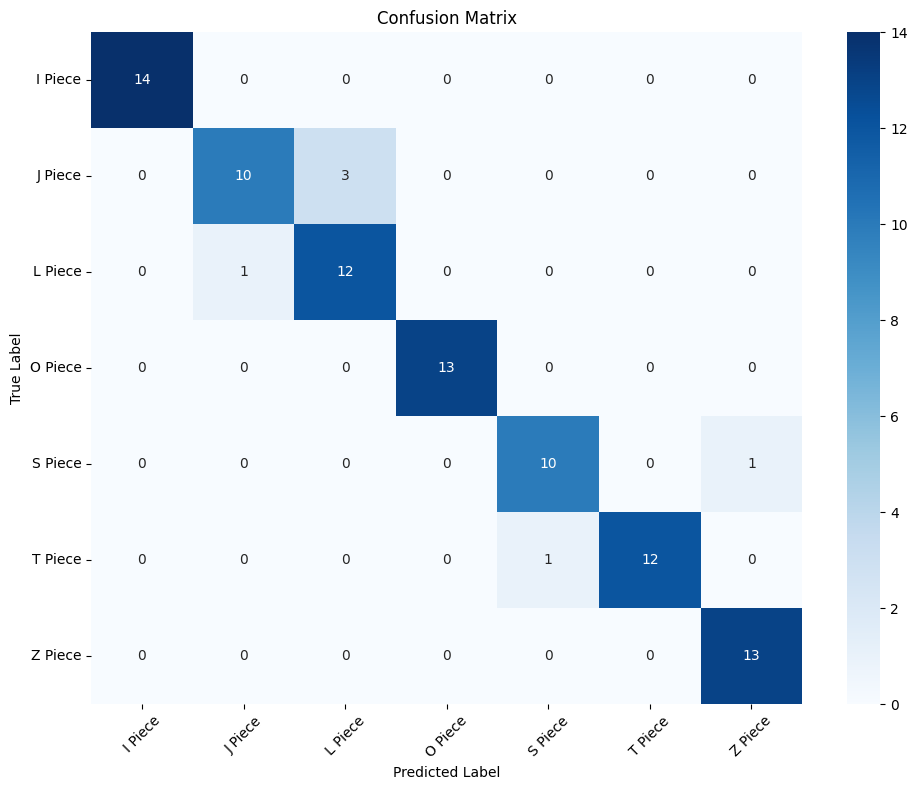

\nPer-class Accuracy:
  I Piece: 1.0000 (14/14)
  J Piece: 0.7692 (10/13)
  L Piece: 0.9231 (12/13)
  O Piece: 1.0000 (13/13)
  S Piece: 0.9091 (10/11)
  T Piece: 0.9231 (12/13)
  Z Piece: 1.0000 (13/13)


In [14]:
# Test evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_labels

print("Evaluating on test set...")
test_accuracy, test_predictions, test_labels = evaluate_model(model, test_loader, device)

print(f"\\nTest Results:")
print(f"  Test Accuracy: {test_accuracy:.2f}%")

# Classification report
class_names = [name.replace('_', ' ').title() for name in label_encoder.classes_]
print("\\nClassification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\\nPer-class Accuracy:")
for i, (class_name, acc) in enumerate(zip(class_names, per_class_accuracy)):
    print(f"  {class_name}: {acc:.4f} ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})")


In [15]:
# Save final model and configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'num_classes': num_classes,
    'label_encoder': label_encoder,
    'test_accuracy': test_accuracy,
    'best_val_accuracy': best_val_acc,
    'model_architecture': 'TetrisCNN',
    'image_size': IMAGE_SIZE,
}, 'tetris_classifier_pytorch.pth')

print("\nModel saved as 'tetris_classifier_pytorch.pth'")
print("\nModel package includes:")
print("  - Model state dict")
print("  - Label encoder")
print("  - Model configuration")
print("  - Performance metrics")

print(f"\n🎯 Final Results Summary:")
print(f"  ✅ Test Accuracy: {test_accuracy:.2f}%")
print(f"  ✅ Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  ✅ Total Parameters: {count_parameters(model):,}")
print(f"  ✅ Training completed successfully!")

# Function to load model for inference
def load_trained_model(model_path, device):
    """Load a trained model for inference"""
    checkpoint = torch.load(model_path, map_location=device)
    
    model = TetrisCNN(checkpoint['num_classes']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    return model, checkpoint['label_encoder'], checkpoint

print("\nTo use this model for inference:")
print("   model, label_encoder, config = load_trained_model('tetris_classifier_pytorch.pth', device)")
print("   # Then use model(image_tensor) for predictions")



Model saved as 'tetris_classifier_pytorch.pth'

Model package includes:
  - Model state dict
  - Label encoder
  - Model configuration
  - Performance metrics

🎯 Final Results Summary:
  ✅ Test Accuracy: 93.33%
  ✅ Best Validation Accuracy: 93.26%
  ✅ Total Parameters: 36,544,199
  ✅ Training completed successfully!

To use this model for inference:
   model, label_encoder, config = load_trained_model('tetris_classifier_pytorch.pth', device)
   # Then use model(image_tensor) for predictions


In [18]:
# Convert model to ONNX format for deployment
import torch.onnx

# The error indicates the model expects 1 channel input, not 3 channels
# This suggests the model was trained on grayscale images, so we need to use 1 channel
dummy_input = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE).to(device)

# Set model to evaluation mode
model.eval()

# Export to ONNX
onnx_path = 'tetris_classifier.onnx'

try:
    torch.onnx.export(
        model,                          # model being run
        dummy_input,                    # model input (or a tuple for multiple inputs)
        onnx_path,                     # where to save the model
        export_params=True,             # store the trained parameter weights inside the model file
        opset_version=11,              # the ONNX version to export the model to
        do_constant_folding=True,       # whether to execute constant folding for optimization
        input_names=['input'],          # the model's input names
        output_names=['output'],        # the model's output names
        dynamic_axes={
            'input': {0: 'batch_size'},    # variable length axes
            'output': {0: 'batch_size'}
        }
    )
    
    print(f"✅ Model successfully exported to ONNX format: {onnx_path}")
    print(f"   Input shape: [batch_size, 1, {IMAGE_SIZE}, {IMAGE_SIZE}] (Grayscale)")
    print(f"   Output shape: [batch_size, {num_classes}]")
    print("   Model is ready for deployment with ONNX Runtime!")
    
except Exception as e:
    print(f"❌ Error exporting model to ONNX: {e}")
    print("   Make sure you have the required dependencies installed:")
    print("   pip install onnx onnxruntime")


C:\Users\Zachary\AppData\Local\Temp\ipykernel_23940\2508494007.py:15: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ Model successfully exported to ONNX format: tetris_classifier.onnx
   Input shape: [batch_size, 1, 128, 128] (Grayscale)
   Output shape: [batch_size, 7]
   Model is ready for deployment with ONNX Runtime!
